# Coherence-Enhancing Diffusion with Optimized Rotation Invariance

**DOI**:  [Weickert 2022](https://doi.org/10.1006/jvci.2001.0495)

In [1]:
import numpy as np
from scipy.signal import convolve2d

from pyfusion import plotting, loading, gaussian

In [2]:
# All the constants

# Data
DIRNAME = "../../data/example_mri"
SCLICE = 70

# Preprocessing
KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001

# Algorithm
ITERATIONS = 1000
STEP_SIZE = 1

In [3]:
# function for later use
def lambda_func(mu_1, mu_2):    # type: ignore
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)  # type: ignore

In [4]:
# Load the data
FSL = loading.load_fsl(DIRNAME, SCLICE)

# Add noise
IMG_noisy = FSL.IMAGE + FSL.IMAGE.std() * NOISE_SCALE * np.random.randn(*FSL.IMAGE.shape)

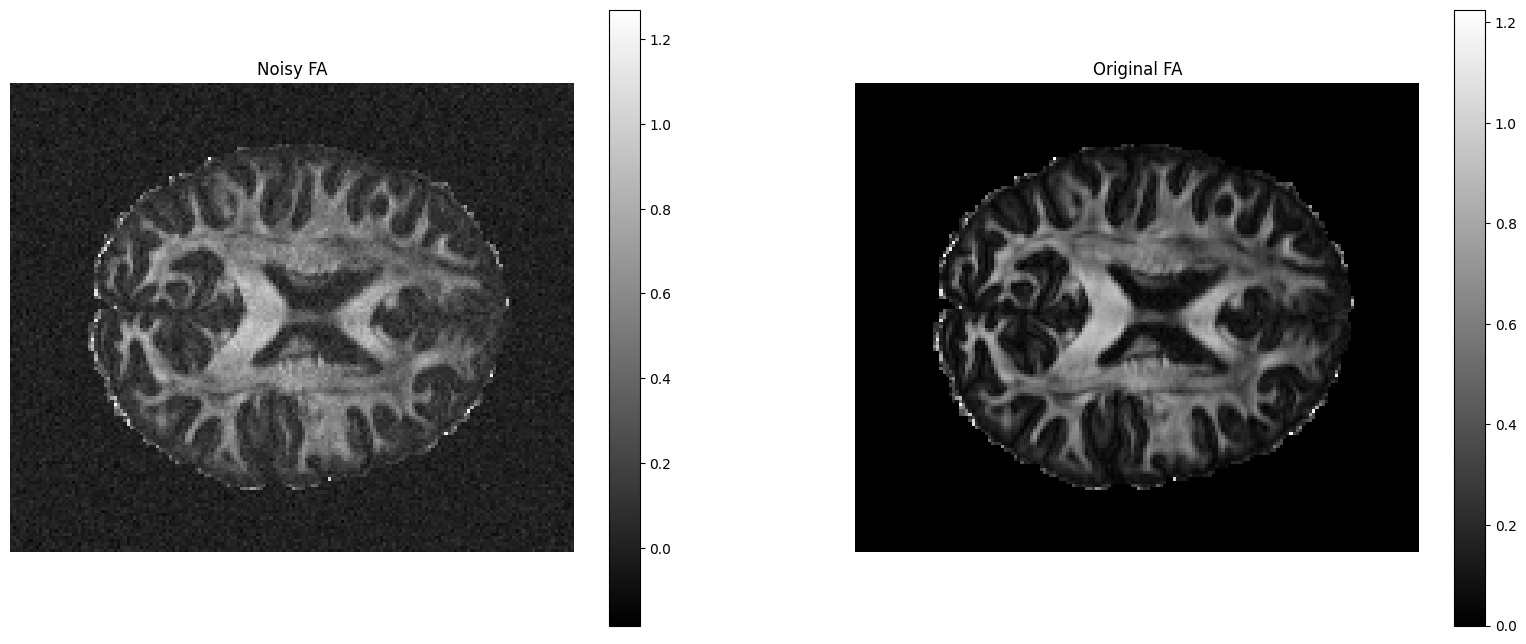

In [5]:
plotting.plot_side_by_side(IMG_noisy, FSL.IMAGE, title_a="Noisy FA", title_b="Original FA")      # type: ignore

To compute the deriviative of the smoothed image (to get the structure tensor) we comupute $\partial_x K_\sigma$ on a quadratic meshgrid, assuming the distance between two cells being 1. The centes is considered to be (0 | 0).
To prepare for the next steps within the main loop, we also compute the kernel for averaging the structure tensor (`K_x` and `K_y`), as well for the last step the kernels for straight forward deriviatives (Weickert uses stencils similar to Sobel).

In [ ]:
coord = np.linspace(-(KERNEL_SIZE - 1) / 2, (KERNEL_SIZE - 1) / 2, KERNEL_SIZE)
x, y = np.meshgrid(coord, coord)

# Create the Gaussian kernels
Gx_noise = gaussian.dx_gaussian(NOISE_SCALE, x, y)   # \partial_x K_\sigma
Gy_noise = gaussian.dy_gaussian(NOISE_SCALE, x, y)   # \partial_y K_\sigma

G_integration = gaussian.gaussian(INTEGRATION_SCALE, x, y)   # K_\rho

D_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])  / 32
D_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

- **(1)**: 
    Now we are calculating the structue tensor being:
    $$
    K_\rho \ast (\nabla u_\sigma \cdot \nabla u_\sigma^T) = 
    \begin{pmatrix}
    K_\rho \ast (\partial_x u_\sigma)^2 & K_\rho \ast (\partial_x u_\sigma \cdot \partial_y u_\sigma) \\
    K_\rho \ast (\partial_x u_\sigma \cdot \partial_y u_\sigma) & K_\rho \ast (\partial_y u_\sigma)^2
    \end{pmatrix}
    $$

    Using the commutative law of convolution, we calculate the kernel before convoluting. Using the notation

    $$
    \begin{pmatrix}
    A & B \\
    B & C
    \end{pmatrix}
    $$
- **(2)**: 
    Now we are calculating the the angle of the first eigenvector, and the eigenvalues of each structure tensor (for each point) with
    $$
    \begin{pmatrix}
    \cos \alpha \\
    \sin \alpha
    \end{pmatrix}
    = v_1 \parallel 
    \begin{pmatrix}
    2B \\
    C - A + \sqrt{(A - C)^2 + 4B^2}
    \end{pmatrix}
    $$
    And the corresponding eigenvalues with
    $$\mu_{1, 2} = \frac{1}{2}(A+C\pm \sqrt{(A - C)^2 + 4B^2})$$
- **(3)**:
    Now as we have the eigen decomposition, we apply CED, by setting new eigenvalues
    $$
    \lambda_1 = \alpha, \lambda_2 =
    \begin{cases}
    \alpha & \text{, if } \mu_1 = \mu_2 \\
    \alpha + (1 - \alpha) \cdot \exp (\frac{-C}{(\mu_1 - \mu_2)^{2m}}) & \text{, else}
    \end{cases}
    $$

    As suggested by Weickert we use $C = 1 = m, \alpha = 0.001$
- **(4)**:
    Then according to weickert the entries of the resulting CED-Diffusion Tensor euquals to
    $$
    D =
    \begin{bmatrix}
    a & b \\
    b & c
    \end{bmatrix}
    =
    \begin{bmatrix}
    \lambda_1 \cos^2 \alpha + \lambda_2 \sin^2 \alpha & (\lambda_1 - \lambda_2) \sin \alpha \cos \alpha \\
    (\lambda_1 - \lambda_2) \sin \alpha \cos \alpha & \lambda_1 \sin^2 \alpha + \lambda_2 \cos^2 \alpha
    \end{bmatrix}
    $$
- **5**:
    Now to compute the final second order diffusion of form (u being the image):
    $$\nabla \cdot (D \nabla u) \\
    = \partial_x(a \partial_x u + b \partial_y u) + \partial_y (b \partial_x u + c \partial_y u)
    $$
    For redability purposes we define:
    $$
    j_1 = a \partial_x u + b \partial_y u \\
    j_2 = b \partial_x u + c \partial_y u
    $$

In [ ]:
img = IMG_noisy.copy()

for _ in range(ITERATIONS):
    ### 1
    A_temp = convolve2d(img, Gx_noise, mode="same", boundary="symm") ** 2 # type: ignore
    A = convolve2d(A_temp, G_integration, mode="same", boundary="symm") # type: ignore

    C_temp = convolve2d(img, Gy_noise, mode="same", boundary="symm") ** 2 # type: ignore
    C = convolve2d(C_temp, G_integration, mode="same", boundary="symm") # type: ignore
    
    B_temp = A_temp * C_temp   # type: ignore
    B = convolve2d(B_temp, G_integration, mode="same", boundary="symm") # type: ignore#

    ### 2
    mu_1 = np.zeros(img.shape)
    mu_2 = np.zeros(img.shape)
    alpha_1 = np.zeros(img.shape)

    discriminant = np.sqrt((A - C) ** 2 + 4 * (B**2))   # type: ignore
    v = np.stack((2 * B, C - A + discriminant), axis=-1)    # type: ignore

    alpha_1 = np.arctan2(v[..., 1], v[..., 0])  # type: ignore
    mu_1 = (A + C + discriminant) / 2   # type: ignore
    mu_2 = (A + C - discriminant) / 2   # type: ignore

    ### 3
    lambda_1 = ALPHA    # type: ignore
    lambda_2 = np.zeros_like(mu_2)  # type: ignore

    mask = np.isclose(mu_1, mu_2)   # type: ignore
    lambda_2[mask] = ALPHA
    lambda_2[~mask] = lambda_func(mu_1[~mask], mu_2[~mask]) # type: ignore

    ### 4
    a = lambda_1 * np.cos(alpha_1)**2 + lambda_2 * np.sin(alpha_1)**2
    b = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
    c = lambda_1 * np.sin(alpha_1)**2 + lambda_2 * np.cos(alpha_1)**2

    ### 5
    j_1 = a * convolve2d(img, D_x, mode="same", boundary="symm") + b * convolve2d(img, D_y, mode="same", boundary="symm") # type: ignore
    j_2 = b * convolve2d(img, D_x, mode="same", boundary="symm") + c * convolve2d(img, D_y, mode="same", boundary="symm") # type: ignore

    delta = convolve2d(j_1, D_x, mode="same", boundary="symm") + convolve2d(j_2, D_y, mode="same", boundary="symm") # type: ignore

    img += STEP_SIZE * delta

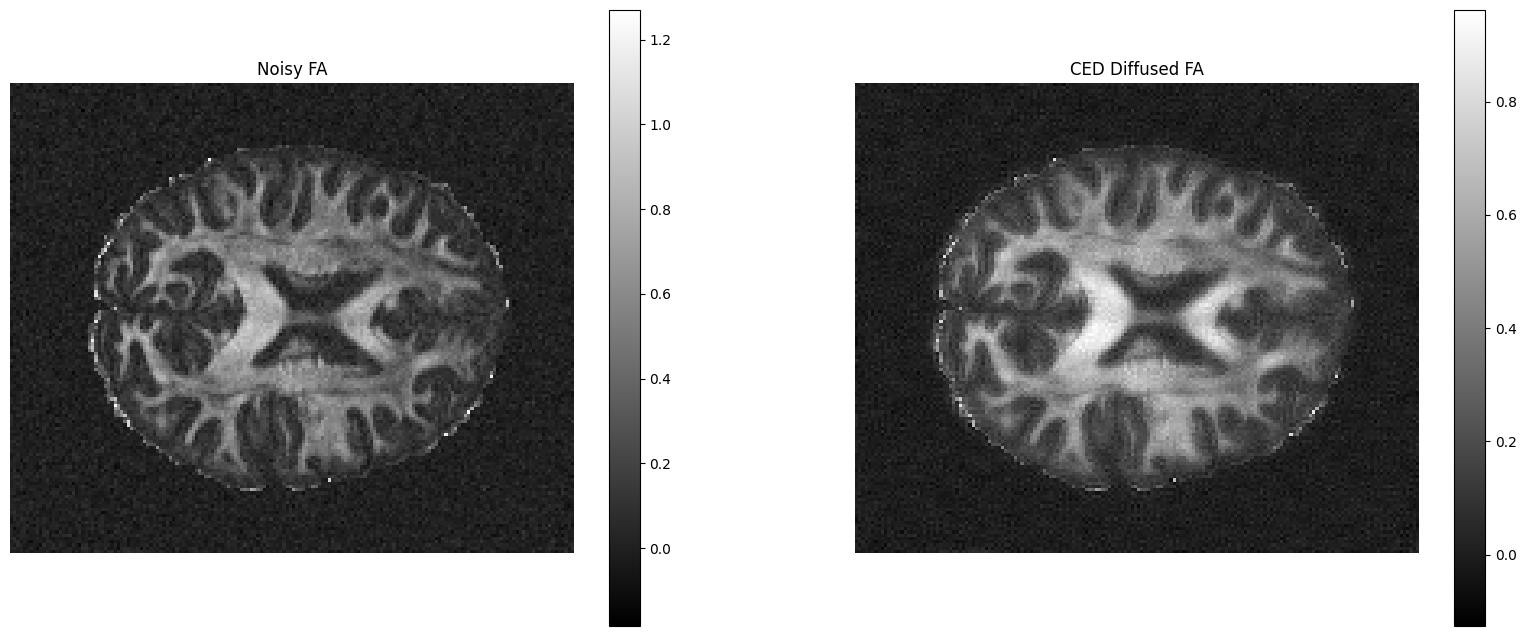

In [8]:
plotting.plot_side_by_side(IMG_noisy, img, title_a="Noisy FA", title_b="CED Diffused FA")  # type: ignore

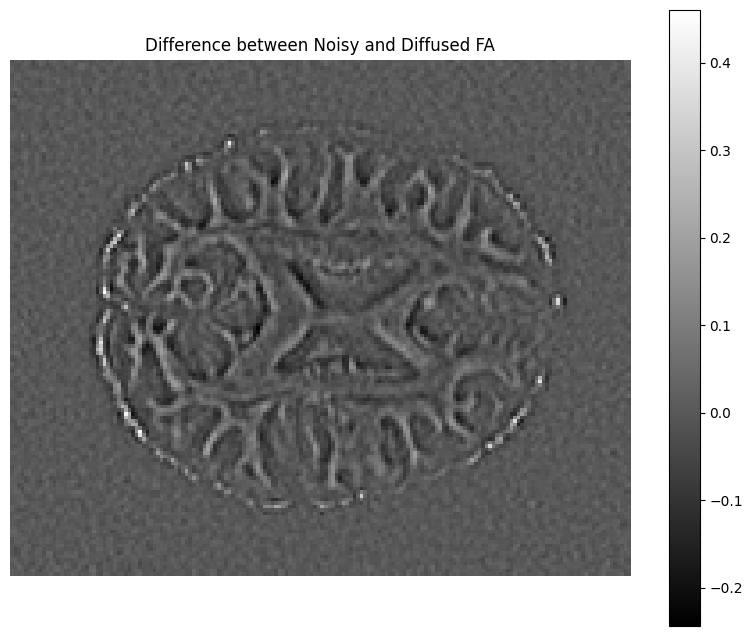

In [9]:
plotting.plot(IMG_noisy-img, title="Difference between Noisy and Diffused FA")  # type: ignore